<a href="https://colab.research.google.com/github/aframuneer26/Deep_Learning_Experiments/blob/main/DL_EXP_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1, Loss 551.630
Epoch 2, Loss 551.631
Epoch 3, Loss 551.630
Epoch 4, Loss 551.618
Epoch 5, Loss 551.616


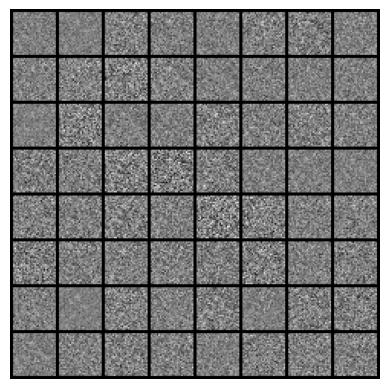

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F, torchvision, matplotlib.pyplot as plt
from torchvision import datasets, transforms; from torch.utils.data import DataLoader

# Config
dev, zdim, bs, ep = torch.device('cuda' if torch.cuda.is_available() else 'cpu'), 20, 128, 5

# Data
dl = DataLoader(datasets.MNIST('data', True, download=True, transform=transforms.ToTensor()), bs, True)

# VAE
class VAE(nn.Module):
    def __init__(self):
        super().__init__(); self.fc1=nn.Linear(784,400); self.mu=nn.Linear(400,zdim); self.lv=nn.Linear(400,zdim)
        self.fc2=nn.Linear(zdim,400); self.fc3=nn.Linear(400,784)
    def forward(self,x):
        h=F.relu(self.fc1(x)); mu,lv=self.mu(h),self.lv(h)
        z=mu+torch.exp(0.5*lv)*torch.randn_like(mu)
        return torch.sigmoid(self.fc3(F.relu(self.fc2(z)))),mu,lv

loss=lambda r,x,mu,lv: F.binary_cross_entropy(r,x,reduction='sum')-0.5*torch.sum(1+lv-mu.pow(2)-lv.exp())

# Train
model,opt=VAE().to(dev),torch.optim.Adam(params=VAE().parameters())
model,opt=VAE().to(dev),torch.optim.Adam(model.parameters())
for e in range(ep):
  L=0
  for x,_ in dl:
    x=x.view(-1,784).to(dev); r,mu,lv=model(x); l=loss(r,x,mu,lv)
    opt.zero_grad(); l.backward(); opt.step(); L+=l.item()
  print(f"Epoch {e+1}, Loss {L/len(dl.dataset):.3f}")

# Generate
with torch.no_grad():
  z=torch.randn(64,zdim).to(dev)
  out=torch.sigmoid(model.fc3(F.relu(model.fc2(z)))).view(-1,1,28,28)
  plt.imshow(torchvision.utils.make_grid(out,nrow=8,normalize=True).permute(1,2,0)); plt.axis('off'); plt.show()
